In [88]:
import numpy as np
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, Reshape, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding, Conv2D, MaxPool2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam

from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import re

import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [89]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [90]:
def load_embeddings(filename):
    embeddings_index = {}
    with open(filename,encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Total %s word vectors in %s' % (len(embeddings_index), filename))
    
    return embeddings_index

In [91]:
def create_embedding_layer(word_index, embeddings_index):
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    
    return Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [92]:
# def create_model(embedding_layer, macronum):
#     sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
#     embedded_sequences = embedding_layer(sequence_input)
#     l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
#     l_pool1 = MaxPooling1D(5)(l_cov1)
#     l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
#     l_pool2 = MaxPooling1D(5)(l_cov2)
#     l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
#     l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
#     l_flat = Flatten()(l_pool3)
#     l_dense = Dense(128, activation='relu')(l_flat)
#     preds = Dense(len(macronum), activation='softmax')(l_dense)
    
#     model = Model(sequence_input, preds)
#     model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc'])

#     print("Simplified convolutional neural network")
#     model.summary()
#     cp = ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
#     return (model, cp)

In [105]:
def create_model(embedding_layer, macronum):
    filter_sizes = [2, 3, 5]
    num_filters = 256
    drop = 0.3
    
    MAX_LENGTH = MAX_SEQUENCE_LENGTH
    
    inputs = Input(shape=(MAX_LENGTH,), dtype='int32')
    embedding = embedding_layer(inputs)

    reshape = Reshape((MAX_LENGTH, EMBEDDING_DIM, 1))(embedding)
    conv_0 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[0], EMBEDDING_DIM), 
                    padding='valid', kernel_initializer='normal', 
                    activation='relu')(reshape)

    conv_1 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[1], EMBEDDING_DIM), 
                    padding='valid', kernel_initializer='normal', 
                    activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, 
                    kernel_size=(filter_sizes[2], EMBEDDING_DIM), 
                    padding='valid', kernel_initializer='normal', 
                    activation='relu')(reshape)

    maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), 
                          strides=(1,1), padding='valid')(conv_0)

    maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), 
                          strides=(1,1), padding='valid')(conv_1)

    maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), 
                          strides=(1,1), padding='valid')(conv_2)
    concatenated_tensor = Concatenate(axis=1)(
        [maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=len(macronum), activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=output)
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    cp = ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
    model.summary()

    return (model, cp)

In [94]:
def load_twenty_newsgroup():
    categories_to_loads = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 
                           'comp.windows.x', 'misc.forsale', 'rec.autos', 
                           'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 
                           'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 
                           'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 
                           'talk.politics.misc', 'talk.religion.misc']
    
    newsgroups_train = fetch_20newsgroups(subset='all', categories=categories_to_loads, 
                                          remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T    
    df.columns = ['text', 'target']
    
    print(newsgroups_train.target_names)
            
    return (df['text'], df['target'])

In [95]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
sw = set(stopwords.words('english'))
    
def preprocess_text(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    
    toks = string.split(' ')
    clean_toks = list(filter(lambda x: x not in sw, toks))
    
    string = ' '.join(clean_toks)
    
    return string.strip().lower()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santonatos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [96]:
import json

def load_yahoo():
    
    texts = []
    labels = []
    
    label_dict = {}
    label_idx = 0
    
    with open('yahoo.json') as f:
        for line in f:
            j = json.loads(line)
            content = j['content']
            annotated_labels = j['annotation']['label']
            
            if len(annotated_labels) == 1:
                texts.append(content)
                label_str = annotated_labels[0]
                
                target = None
                if label_str in label_dict:
                    target = label_dict[label_str]
                else:
                    label_dict[label_str] = label_idx
                    target = label_idx
                    label_idx += 1
                    
                labels.append(target)
    
    return (texts, labels)

In [97]:
def load_data(data_ref):

    data_ref_dict = { 
        'yahoo': load_yahoo,
        '20news': load_twenty_newsgroup
    }
    
    texts, labels = data_ref_dict[data_ref]() #load_twenty_newsgroup()
  
    texts = list(map(preprocess_text, texts)) #df['text'].apply(preprocess_text)
    
    macronum=sorted(set(labels))
    
    print(macronum)
    
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Number of Unique Tokens',len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    labels = to_categorical(np.asarray(labels))
    print('Shape of Data Tensor:', data.shape)
    print('Shape of Label Tensor:', labels.shape)

    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

    x_train = data[:-nb_validation_samples]
    y_train = labels[:-nb_validation_samples]
    x_val = data[-nb_validation_samples:]
    y_val = labels[-nb_validation_samples:]
    
    return (x_train, y_train, x_val, y_val, word_index, macronum)

In [98]:
embeddings_filename = 'glove.6B.' + str(EMBEDDING_DIM) + 'd.txt'
embeddings_index = load_embeddings(embeddings_filename)

Total 400000 word vectors in glove.6B.100d.txt


In [103]:
x_train, y_train, x_val, y_val, word_index, macronum = load_data('20news')

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Number of Unique Tokens 133146
Shape of Data Tensor: (17883, 1000)
Shape of Label Tensor: (17883, 19)


In [106]:
print(macronum)
embedding_layer = create_embedding_layer(word_index, embeddings_index)
model, cp = create_model(embedding_layer, macronum)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1000, 100)    13314700    input_17[0][0]                   
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 1000, 100, 1) 0           embedding_18[0][0]               
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 999, 1, 256)  51456       reshape_9[0][0]                  
__________________________________________

In [107]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=5, batch_size=256, callbacks=[cp])

Train on 14307 samples, validate on 3576 samples
Epoch 1/5
14307/14307 [==============================] - 211s 15ms/step - loss: 0.3641 - acc: 0.8724 - val_loss: 0.2112 - val_acc: 0.9474

Epoch 00001: val_acc improved from -inf to 0.94737, saving model to model_cnn.hdf5
Epoch 2/5
14307/14307 [==============================] - 215s 15ms/step - loss: 0.2231 - acc: 0.9468 - val_loss: 0.1997 - val_acc: 0.9474

Epoch 00002: val_acc did not improve from 0.94737
Epoch 3/5
14307/14307 [==============================] - 234s 16ms/step - loss: 0.2107 - acc: 0.9470 - val_loss: 0.1893 - val_acc: 0.9474

Epoch 00003: val_acc did not improve from 0.94737
Epoch 4/5
14307/14307 [==============================] - 227s 16ms/step - loss: 0.2009 - acc: 0.9470 - val_loss: 0.1808 - val_acc: 0.9474

Epoch 00004: val_acc improved from 0.94737 to 0.94738, saving model to model_cnn.hdf5
Epoch 5/5
14307/14307 [==============================] - 222s 16ms/step - loss: 0.1911 - acc: 0.9474 - val_loss: 0.1728 - val_

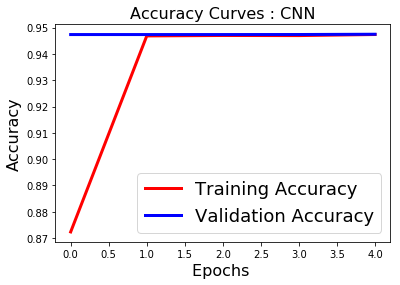

In [108]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()